In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
import numpy as np

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
class GNB:
    def __init__(self):
        self.priors = {}
        self.means = {}
        self.variances = {}
        self.classes = []
    
    def fit(self, X, y):
        # Convert to numpy arrays if they're pandas objects
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y = y.values
            
        self.classes = np.unique(y)
        n_samples = X.shape[0]
        
        for c in self.classes:
            X_c = X[y == c]
            self.priors[c] = X_c.shape[0] / n_samples
            self.means[c] = np.mean(X_c, axis=0)
            self.variances[c] = np.var(X_c, axis=0)
    
    def gaussian_pdf(self, x, mean, var, epsilon=1e-9):
        # Convert to numpy arrays if they're pandas objects
        if isinstance(x, pd.Series):
            x = x.values
        if isinstance(mean, pd.Series):
            mean = mean.values
        if isinstance(var, pd.Series):
            var = var.values
            
        return (1 / np.sqrt(2 * np.pi * (var + epsilon))) * np.exp(-((x - mean) ** 2) / (2 * (var + epsilon)))
    
    def predict_proba(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        # Initialize array of zeros (n_samples, n_classes)
        probs = np.zeros((X.shape[0], len(self.classes)))
    
        for i, x in enumerate(X):
            posteriors = {}
            for j, c in enumerate(self.classes):
                prior = np.log(self.priors[c])
                likelihood = np.sum(np.log(self.gaussian_pdf(x, self.means[c], self.variances[c])))
                posteriors[c] = prior + likelihood
        
            # Softmax and store in pre-allocated array
            exp_probs = np.exp(list(posteriors.values()))
            probs[i] = exp_probs / np.sum(exp_probs)
    
        return probs  # Shape: (n_samples, n_classes)
    
    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

NB - Unbalanced Dataset

In [4]:
# Load dataset
df = pd.read_csv("../Datasets/Unbalanced_Multiclass.csv")
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,target
0,1.942833,1.793557,-6.121474,-1.031132,0.487107,-0.346116,0.242493,-0.255091,-1.933793,0.456129,...,0.021294,-0.876791,-2.804382,-0.772752,0.902250,-0.283821,1.158110,-0.703144,-1.142507,8
1,-0.498266,4.290355,0.924083,-1.281493,8.153378,-2.302476,0.615296,-3.871441,1.491185,3.666561,...,-0.030226,1.076776,-1.426662,0.743057,0.212868,1.043947,0.948273,0.706128,-0.491125,8
2,-1.027512,3.363755,1.828574,-0.495802,7.458820,-2.484852,0.378415,-2.248700,-1.301424,4.136351,...,0.472101,1.206932,-0.923404,0.566657,0.293071,-0.145078,1.759649,0.516351,0.492429,8
3,2.736756,-2.241731,0.404660,-0.167861,-0.125442,0.496706,1.664382,-1.271026,0.213782,0.962099,...,-1.376614,-0.559114,-0.335620,0.088591,0.080121,-0.085828,0.038390,-0.096909,-0.426436,8
4,0.685796,0.223385,-2.080131,-0.011414,4.090118,0.650177,2.411078,2.637664,-1.594057,0.283371,...,0.540901,0.354731,-0.933172,-0.888606,0.902017,0.506791,0.640292,0.129010,0.092228,8


In [5]:
# Check class distribution
print("\nClass distribution:")
print(df['target'].value_counts())


Class distribution:
target
8     367
3      80
2      16
1      15
0      15
7       7
13      6
9       4
11      2
4       1
5       1
10      1
6       1
12      1
Name: count, dtype: int64


In [6]:
# List of classes to remove
classes_to_remove = {4, 5, 6, 10, 11, 12}

# Filter rows where target is not in classes_to_remove
df = df[~df['target'].isin(classes_to_remove)]

print("\nClass distribution:")
print(df['target'].value_counts())


Class distribution:
target
8     367
3      80
2      16
1      15
0      15
7       7
13      6
9       4
Name: count, dtype: int64


In [7]:
# Splitting features and target
X = df.drop(columns=['target'])
y = df['target']

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print shapes
print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (408, 29)
Test set shape: (102, 29)


In [25]:
print("Unique classes in y_test:", np.unique(y_test))
print("Number of unique classes:", len(np.unique(y_test)))

Unique classes in y_test: [ 0  1  2  3  7  8  9 13]
Number of unique classes: 8


Number of unique classes: 5

Accuracy: 13.725%

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         3
           2       0.25      0.33      0.29         3
           3       0.68      0.81      0.74        16
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00        73
           9       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1

    accuracy                           0.14       102
   macro avg       0.09      0.11      0.10       102
weighted avg       0.11      0.14      0.12       102


Confusion Matrix:


c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\raj

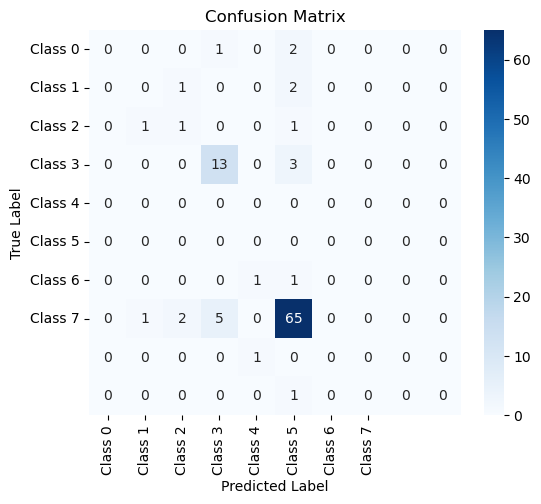

In [ ]:
# Create and train Gaussian Naive Bayes classifier
gnb = GNB()
gnb.fit(X_train, y_train)

# Make predictions
y_pred = gnb.predict(X_test)
y_probs = gnb.predict_proba(X_test)


# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy*100:.3f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
#print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[f"Class {i}" for i in range(len(np.unique(y_test)))], 
            yticklabels=[f"Class {i}" for i in range(len(np.unique(y_test)))])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [9]:
# Calculate sensitivity and specificity for each class
def class_sensitivity_specificity(cm, classes):
    metrics = {}
    for i, class_label in enumerate(classes):
        TP = cm[i,i]
        FN = sum(cm[i,:]) - TP
        FP = sum(cm[:,i]) - TP
        TN = cm.sum() - (TP + FP + FN)
        
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        
        metrics[class_label] = {
            'sensitivity': sensitivity,
            'specificity': specificity
        }
    return metrics

# Calculate metrics for each class
class_metrics = class_sensitivity_specificity(cm, np.unique(y))

# Print metrics for each class
print("\nClass-wise Metrics:")
for class_label, metrics in class_metrics.items():
    print(f"\nClass {class_label}:")
    print(f"Sensitivity: {metrics['sensitivity']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")

# Calculate overall sensitivity and specificity
TN, FP, FN, TP = cm.ravel()
overall_sensitivity = TP / (TP + FN)
overall_specificity = TN / (TN + FP)
print("\nOverall Metrics:")
print(f"Sensitivity: {overall_sensitivity:.4f}")
print(f"Specificity: {overall_specificity:.4f}")

# ROC Curve
def plot_roc_curve(y_test, y_scores, classes):
    y_test_bin = np.zeros((len(y_test), len(classes)))
    for i, c in enumerate(classes):
        y_test_bin[:, i] = (y_test == c).astype(int)
    
    plt.figure()
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_roc_curve(y_test, y_probs, classes=np.unique(y))

IndexError: index 9 is out of bounds for axis 0 with size 9

NB - Balanced Dataset

In [10]:
# Load dataset
df = pd.read_csv("../Datasets/Balanced_Multiclass.csv")
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,target
0,1.942833,1.793557,-6.121474,-1.031132,0.487107,-0.346116,0.242493,-0.255091,-1.933793,0.456129,...,0.021294,-0.876791,-2.804382,-0.772752,0.902250,-0.283821,1.158110,-0.703144,-1.142507,8
1,-0.498266,4.290355,0.924083,-1.281493,8.153378,-2.302476,0.615296,-3.871441,1.491185,3.666561,...,-0.030226,1.076776,-1.426662,0.743057,0.212868,1.043947,0.948273,0.706128,-0.491125,8
2,-1.027512,3.363755,1.828574,-0.495802,7.458820,-2.484852,0.378415,-2.248700,-1.301424,4.136351,...,0.472101,1.206932,-0.923404,0.566657,0.293071,-0.145078,1.759649,0.516351,0.492429,8
3,2.736756,-2.241731,0.404660,-0.167861,-0.125442,0.496706,1.664382,-1.271026,0.213782,0.962099,...,-1.376614,-0.559114,-0.335620,0.088591,0.080121,-0.085828,0.038390,-0.096909,-0.426436,8
4,0.685796,0.223385,-2.080131,-0.011414,4.090118,0.650177,2.411078,2.637664,-1.594057,0.283371,...,0.540901,0.354731,-0.933172,-0.888606,0.902017,0.506791,0.640292,0.129010,0.092228,8


In [11]:
print("\nClass distribution:")
print(df['target'].value_counts())


Class distribution:
target
8     367
3     367
13    367
2     367
4     367
5     367
6     367
10    367
1     367
11    367
7     367
0     367
12    367
9     367
Name: count, dtype: int64


In [12]:
# Splitting features and target
X = df.drop(columns=['target'])
y = df['target']

In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (4110, 29)
Test set shape: (1028, 29)


In [14]:
"""
Scaling is not needed as it is a probability based model
"""

'\nScaling is not needed as it is a probability based model\n'

C:\Users\rajit\AppData\Local\Temp\ipykernel_19316\2549305743.py:46: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(np.log(self.gaussian_pdf(x, self.means[c], self.variances[c])))



Accuracy: 92.121%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.58      0.71        78
           1       0.83      0.90      0.86        67
           2       0.90      0.87      0.88        69
           3       0.71      0.90      0.80        80
           4       1.00      1.00      1.00        75
           5       1.00      1.00      1.00        65
           6       1.00      1.00      1.00        72
           7       0.85      0.95      0.90        82
           8       0.83      0.76      0.79        83
           9       0.98      1.00      0.99        79
          10       1.00      1.00      1.00        74
          11       1.00      1.00      1.00        59
          12       1.00      1.00      1.00        71
          13       1.00      1.00      1.00        74

    accuracy                           0.92      1028
   macro avg       0.93      0.93      0.92      1028
weighted avg       0.93      0.92    

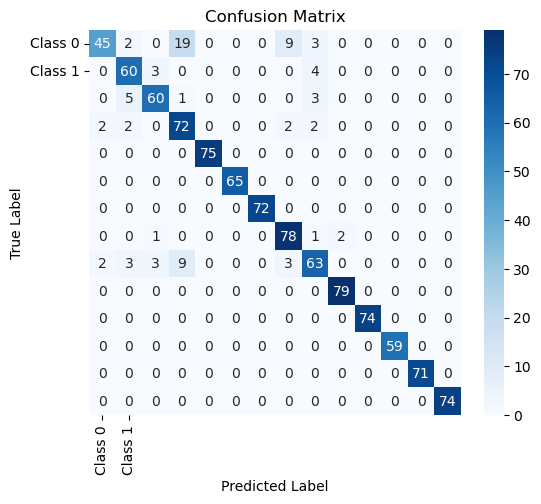

In [15]:
# Create and train Gaussian Naive Bayes classifier
gnb = GNB()
gnb.fit(X_train, y_train)

# Make predictions
y_pred = gnb.predict(X_test)
y_probs = gnb.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy*100:.3f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Class 0", "Class 1"], 
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [16]:
# Calculate sensitivity and specificity for each class
def class_sensitivity_specificity(cm, classes):
    metrics = {}
    for i, class_label in enumerate(classes):
        TP = cm[i,i]
        FN = sum(cm[i,:]) - TP
        FP = sum(cm[:,i]) - TP
        TN = cm.sum() - (TP + FP + FN)
        
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        
        metrics[class_label] = {
            'sensitivity': sensitivity,
            'specificity': specificity
        }
    return metrics

# Calculate metrics for each class
class_metrics = class_sensitivity_specificity(cm, np.unique(y))

# Print metrics for each class
print("\nClass-wise Metrics:")
for class_label, metrics in class_metrics.items():
    print(f"\nClass {class_label}:")
    print(f"Sensitivity: {metrics['sensitivity']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")

# Calculate overall sensitivity and specificity
TN, FP, FN, TP = cm.ravel()
overall_sensitivity = TP / (TP + FN)
overall_specificity = TN / (TN + FP)
print("\nOverall Metrics:")
print(f"Sensitivity: {overall_sensitivity:.4f}")
print(f"Specificity: {overall_specificity:.4f}")

# ROC Curve
def plot_roc_curve(y_test, y_scores, classes):
    y_test_bin = np.zeros((len(y_test), len(classes)))
    for i, c in enumerate(classes):
        y_test_bin[:, i] = (y_test == c).astype(int)
    
    plt.figure()
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_roc_curve(y_test, y_probs, classes=np.unique(y))


Class-wise Metrics:

Class 0:
Sensitivity: 0.5769
Specificity: 0.9958

Class 1:
Sensitivity: 0.8955
Specificity: 0.9875

Class 2:
Sensitivity: 0.8696
Specificity: 0.9927

Class 3:
Sensitivity: 0.9000
Specificity: 0.9694

Class 4:
Sensitivity: 1.0000
Specificity: 1.0000

Class 5:
Sensitivity: 1.0000
Specificity: 1.0000

Class 6:
Sensitivity: 1.0000
Specificity: 1.0000

Class 7:
Sensitivity: 0.9512
Specificity: 0.9852

Class 8:
Sensitivity: 0.7590
Specificity: 0.9862

Class 9:
Sensitivity: 1.0000
Specificity: 0.9979

Class 10:
Sensitivity: 1.0000
Specificity: 1.0000

Class 11:
Sensitivity: 1.0000
Specificity: 1.0000

Class 12:
Sensitivity: 1.0000
Specificity: 1.0000

Class 13:
Sensitivity: 1.0000
Specificity: 1.0000


ValueError: too many values to unpack (expected 4)

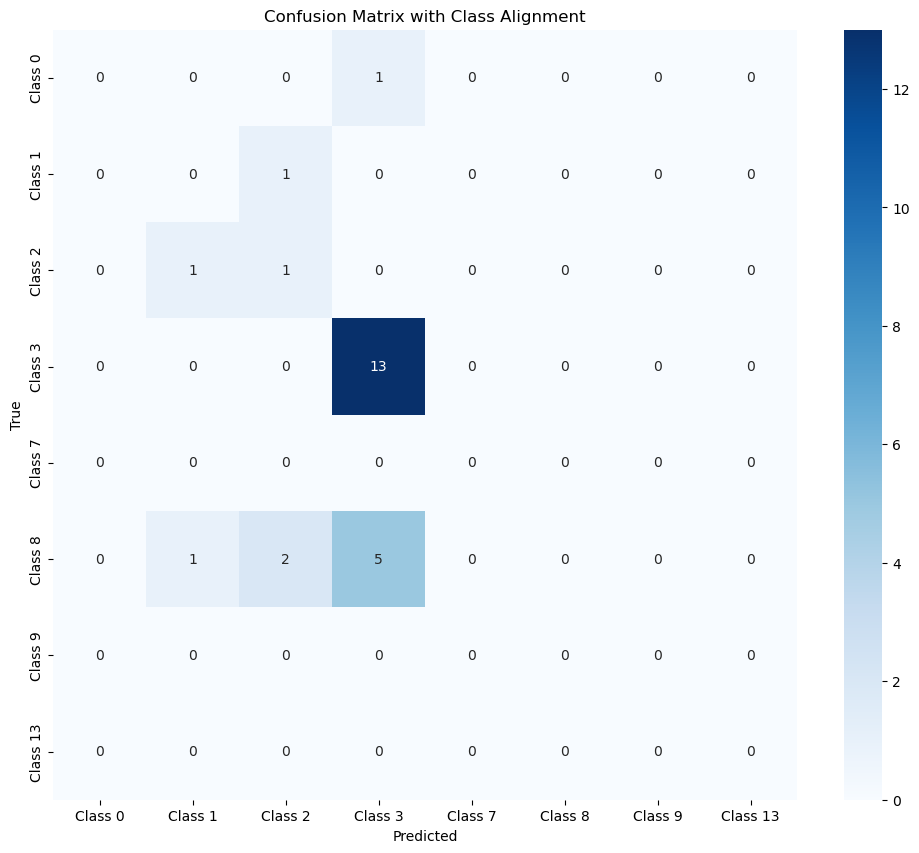


Classification Report:


c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\_array_api.py:399: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_pred contains NaN.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                            roc_curve, auc, classification_report)
from sklearn.preprocessing import label_binarize

np.random.seed(42)

class GNB:
    def __init__(self):
        self.priors = {}
        self.means = {}
        self.variances = {}
        self.classes = []
    
    def fit(self, X, y):
        X = X.values if isinstance(X, pd.DataFrame) else X
        y = y.values if isinstance(y, (pd.DataFrame, pd.Series)) else y
        
        self.classes, counts = np.unique(y, return_counts=True)
        n_samples = X.shape[0]
        
        for c in self.classes:
            X_c = X[y == c]
            self.priors[c] = X_c.shape[0] / n_samples
            self.means[c] = np.mean(X_c, axis=0)
            self.variances[c] = np.var(X_c, axis=0)
    
    def gaussian_pdf(self, x, mean, var, epsilon=1e-9):
        x = x.values if isinstance(x, pd.Series) else x
        mean = mean.values if isinstance(mean, pd.Series) else mean
        var = var.values if isinstance(var, pd.Series) else var
        return (1 / np.sqrt(2 * np.pi * (var + epsilon))) * np.exp(
            -((x - mean) ** 2) / (2 * (var + epsilon))
        )
    
    def predict_proba(self, X):
        X = X.values if isinstance(X, pd.DataFrame) else X
        probs = np.zeros((X.shape[0], len(self.classes)))
        
        for i, x in enumerate(X):
            posteriors = {}
            for j, c in enumerate(self.classes):
                prior = np.log(self.priors[c])
                likelihood = np.sum(np.log(self.gaussian_pdf(x, self.means[c], self.variances[c])))
                posteriors[c] = prior + likelihood
            
            exp_probs = np.exp(list(posteriors.values()))
            probs[i] = exp_probs / np.sum(exp_probs)
        
        return probs
    
    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

# Load and prepare data
df = pd.read_csv("../Datasets/Unbalanced_Multiclass.csv")
classes_to_remove = {4, 5, 6, 10, 11, 12}
df = df[~df['target'].isin(classes_to_remove)]

# Split data with manual stratification
X = df.drop(columns=['target'])
y = df['target']

# Get initial class distribution
original_classes = np.unique(y)

# Train-test split ensuring all classes are present
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
gnb = GNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
y_probs = gnb.predict_proba(X_test)

# Handle class alignment
all_classes = gnb.classes

# Convert to categorical with all classes
y_test = pd.Categorical(y_test, categories=all_classes)
y_pred = pd.Categorical(y_pred, categories=all_classes)

# Convert to numerical codes for confusion matrix
y_test_codes = y_test.codes
y_pred_codes = y_pred.codes

# Filter out missing categories (-1 indicates missing)
valid_mask = (y_test_codes != -1) & (y_pred_codes != -1)
y_test_final = y_test_codes[valid_mask]
y_pred_final = y_pred_codes[valid_mask]

# Generate confusion matrix
cm = confusion_matrix(y_test_final, y_pred_final, labels=range(len(all_classes)))

# Create class labels
class_labels = [f"Class {c}" for c in all_classes]

# Visualization
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix with Class Alignment")
plt.show()

# Classification report with all classes
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_labels, zero_division=0))

# Sensitivity/Specificity calculation
def safe_divide(a, b):
    return a / b if b != 0 else 0.0

def class_sensitivity_specificity(cm, classes):
    metrics = {}
    n_classes = len(classes)
    total = cm.sum()
    
    for i in range(n_classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = total - (TP + FP + FN)
        
        sensitivity = safe_divide(TP, TP + FN)
        specificity = safe_divide(TN, TN + FP)
        
        metrics[classes[i]] = {
            'sensitivity': round(sensitivity, 4),
            'specificity': round(specificity, 4)
        }
    return metrics

class_metrics = class_sensitivity_specificity(cm, all_classes)
print("\nClass-wise Metrics:")
for cls in all_classes:
    print(f"Class {cls}:")
    print(f"  Sensitivity: {class_metrics[cls]['sensitivity']}")
    print(f"  Specificity: {class_metrics[cls]['specificity']}\n")

# ROC Curve with all classes
def plot_enhanced_roc(y_true, y_probs, classes):
    y_true_bin = label_binarize(y_true, classes=classes)
    
    plt.figure(figsize=(12, 10))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    
    for i, cls in enumerate(classes):
        if y_true_bin[:, i].sum() == 0:
            continue  # Skip classes with no positive samples
            
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, color=colors[i], lw=2,
                 label=f'Class {cls} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_enhanced_roc(y_test, y_probs, all_classes)